# Example glider data analysis

Once we have some glider missions of interest, we can start downloading them.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime
from matplotlib import style
style.use('presentation.mplstyle')
import cartopy
import cartopy.crs as ccrs
import gsw
import utils

### 1. Get a list of datasets of interest

One can make of glider-mission combinations by examining maps and figures from the [observations portal](https://observations.voiceoftheocean.org/) and generating a list of glider missions. Alternatively, one can programatically interogate the ERDDAP itself to find datasets that match certain criteria, see [notebook 01](01_mission_filter.ipynb).

Either way, you end up with a list of datasetIDs like this:



In [2]:
datasets_to_download = ['delayed_SEA068_M27', 'nrt_SEA068_M27', 'delayed_SEA069_M9',
       'nrt_SEA069_M9', 'delayed_SEA067_M26', 'nrt_SEA067_M26',
       'delayed_SEA067_M27', 'nrt_SEA067_M27', 'delayed_SEA067_M29',
       'nrt_SEA067_M29', 'delayed_SEA067_M30', 'nrt_SEA067_M30',
       'delayed_SEA067_M32', 'nrt_SEA067_M32', 'delayed_SEA063_M35',
       'delayed_SEA066_M41', 'nrt_SEA066_M41',
       'delayed_SEA066_M42', 'nrt_SEA066_M42', 'delayed_SEA066_M43',
       'nrt_SEA066_M43']

These are datasets that extended to > 150 m depth in the seas northeast of Gotland

### 2. Quick check with nrt datasets

For preliminary analysis, I recommend downloading only the NRT (near real time) datasets, as these are ~ 100 times smaller than the delayed mode data and are much quicker to work with. To achieve this, we use the `nrt_only=True` kwarg

In [3]:
ds_dict = utils.download_glider_dataset(datasets_to_download, nrt_only=True)

delayed_SEA068_M27 is not nrt. Ignoring
delayed_SEA069_M9 is not nrt. Ignoring
delayed_SEA067_M26 is not nrt. Ignoring
delayed_SEA067_M27 is not nrt. Ignoring
delayed_SEA067_M29 is not nrt. Ignoring
delayed_SEA067_M30 is not nrt. Ignoring
delayed_SEA067_M32 is not nrt. Ignoring
delayed_SEA063_M35 is not nrt. Ignoring
delayed_SEA066_M41 is not nrt. Ignoring
delayed_SEA066_M42 is not nrt. Ignoring
delayed_SEA066_M43 is not nrt. Ignoring


  0%|          | 0/10 [00:00<?, ?it/s]

This function returns a dictionary where the keys are dataset IDs and the values are the datasets as xarray objects

### 3. Initial analysis

Here we will create some quick plots to check that the datasets have what we need

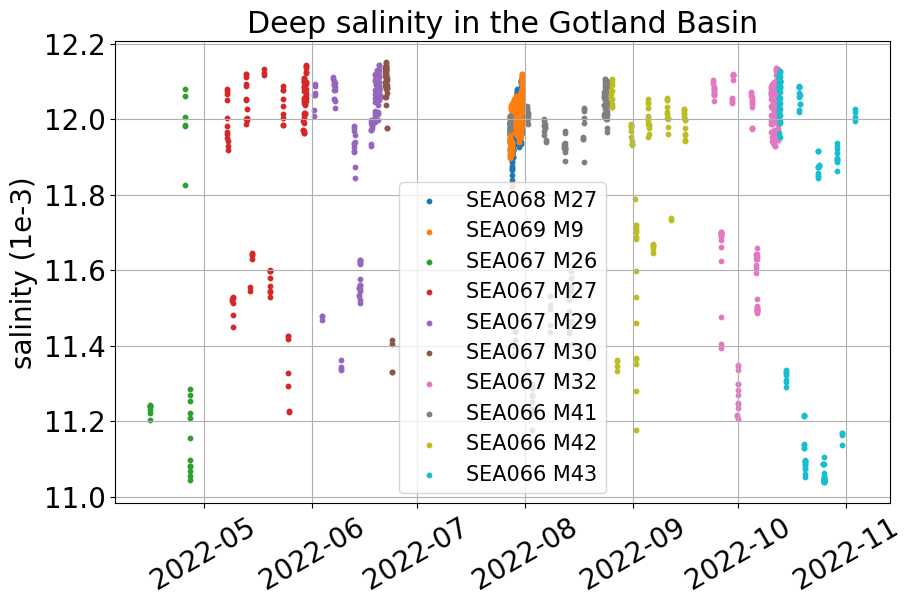

In [4]:
min_depth = 140
fig, ax = plt.subplots(figsize=(10, 6))
for name, ds in ds_dict.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    ax.scatter(ds.time[ds.depth> min_depth], ds.salinity[ds.depth> min_depth], label=pretty_label, s=10)
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})", title="Deep salinity in the Gotland Basin")
plt.grid()

A small map of the area

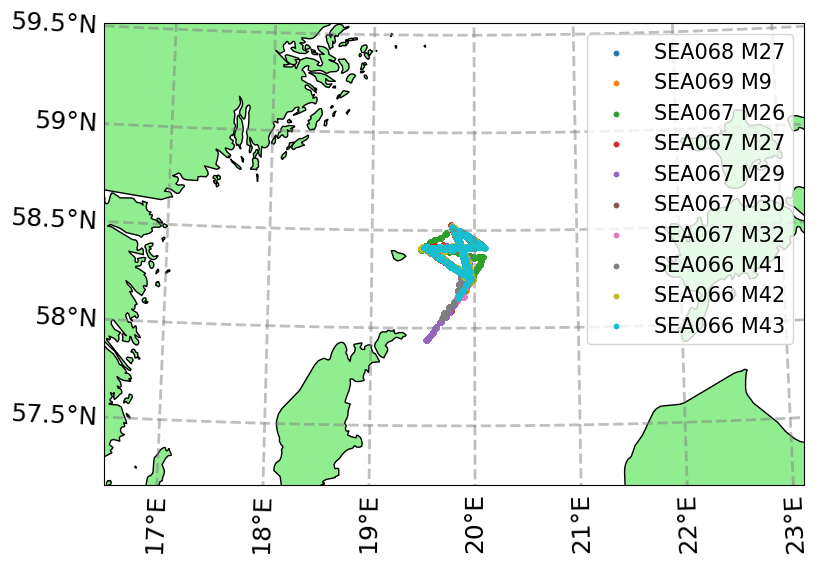

In [5]:
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=np.mean(ds.longitude.values),
                                  central_latitude=np.mean(ds.latitude.values))
pc = cartopy.crs.PlateCarree()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection=coord)

for name, ds in ds_dict.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    ax.scatter(ds.longitude.values, ds.latitude.values, transform=pc, s=10, label=pretty_label)
lon_extend = 3
lat_extend = 1
lims = (np.nanmin(ds.longitude.values) - lon_extend, np.nanmax(ds.longitude.values) + lon_extend,
        np.nanmin(ds.latitude.values) - lat_extend, np.nanmax(ds.latitude.values) + lat_extend)
ax.set_extent(lims, crs=pc)

feature = cartopy.feature.NaturalEarthFeature(name='land', category='physical',
                                       scale='10m', edgecolor='black', facecolor='lightgreen')
ax.add_feature(feature)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = None
gl.right_labels = None
ax.legend();

Maybe there's a geographical gradient at play too? There appears to be a bimodal distribution of salinity. Rather than a timeseries, let's plot against latitude and longitude

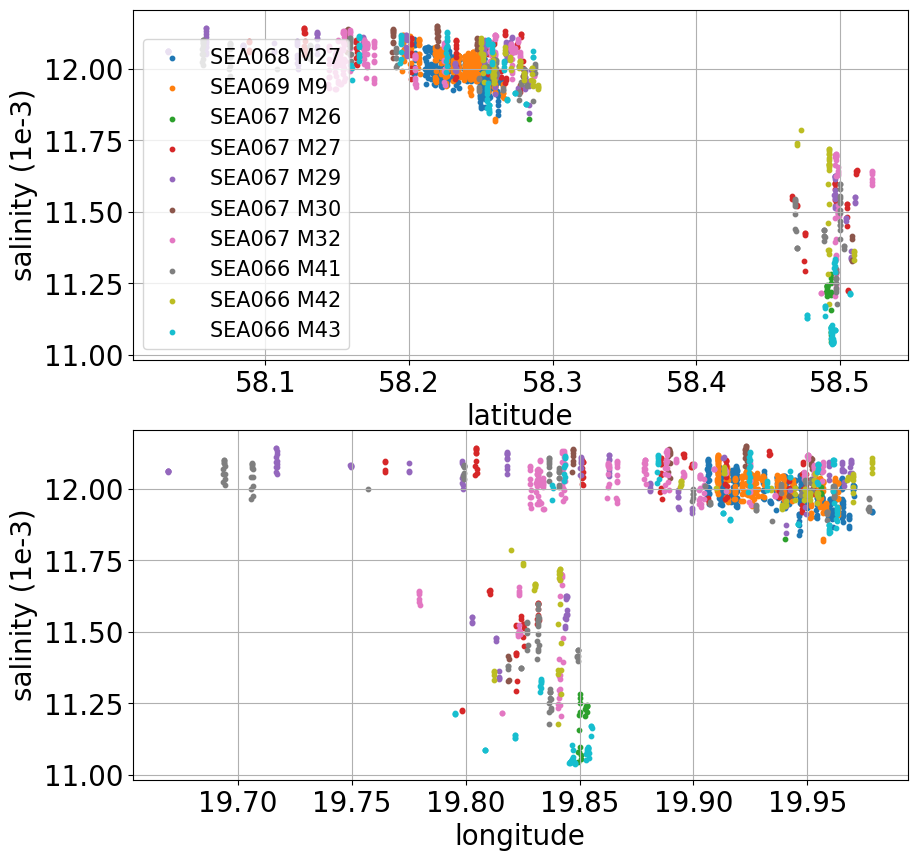

In [6]:
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(10, 10))
for name, ds in ds_dict.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    ax0.scatter(ds.latitude[ds.depth> min_depth], ds.salinity[ds.depth> min_depth], label=pretty_label, s=10)
    ax1.scatter(ds.longitude[ds.depth> min_depth], ds.salinity[ds.depth> min_depth], label=pretty_label, s=10)
ax0.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax0.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})", xlabel="latitude")
ax1.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})", xlabel="longitude")
ax0.grid()
ax1.grid()

There's definitely some spatial vartiability here. Maybe a seperate sub-basin to the southeast? There's a ridge between them, explaining the gap in latitude of our deep data. Let's subset our data a bit before plotting it

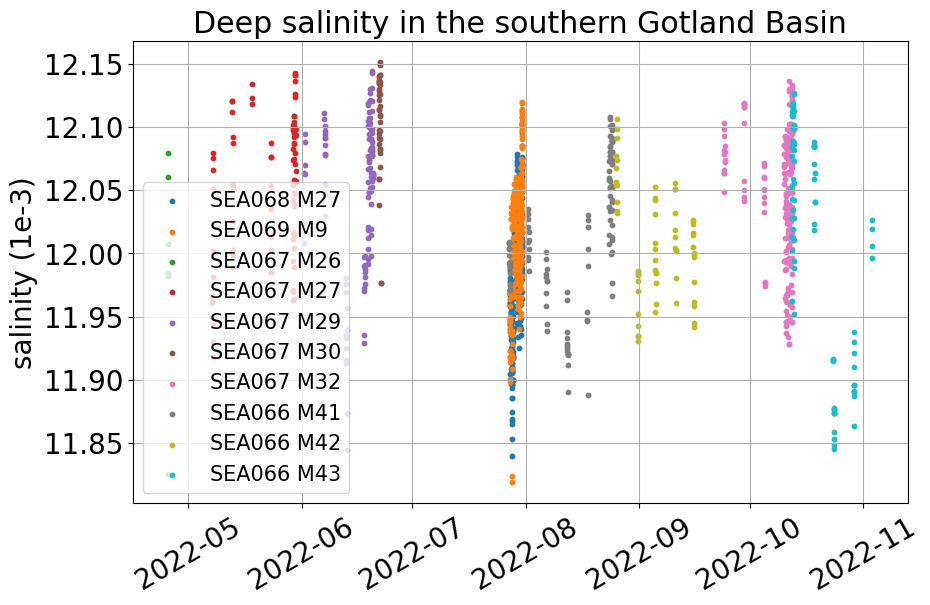

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
for name, ds in ds_dict.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    mask = (ds.depth.values > min_depth) * (ds.latitude.values<58.4)
    ax.scatter(ds.time[mask], ds.salinity[mask], label=pretty_label, s=10)
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})", title="Deep salinity in the southern Gotland Basin")
plt.grid()

### 4. Download the full datasets

Once we are confident that the dataset contain something of interest, we can download the full size delayed mode datasets. This uses a cache of data in the directory `voto_erddap_data_cache` to avoid duplicate downloads.

**To force data to re-download, simply delete the cache dir**. You should do this periodically to get the most up to date datasets


Delayed mode datasets are big! To speed up the download, and reduce the load on the server, we can specify just the variables that we want and the server-side subsetting of depth. We use the `variables` and `constraints` kwargs

In [8]:
variables = [
     'latitude',
     'longitude',
     'time',
     'depth',
     'profile_direction',
     'profile_index',
     'salinity',
     'salinity_qc']

constraints = {"depth>=": 140,
              "latitude>=": 58.4}

In [9]:
ds_delayed = utils.download_glider_dataset(datasets_to_download, delayed_only=True,
                                          variables=variables, constraints=constraints)

nrt_SEA068_M27 is not delayed. Ignoring
nrt_SEA069_M9 is not delayed. Ignoring
nrt_SEA067_M26 is not delayed. Ignoring
nrt_SEA067_M27 is not delayed. Ignoring
nrt_SEA067_M29 is not delayed. Ignoring
nrt_SEA067_M30 is not delayed. Ignoring
nrt_SEA067_M32 is not delayed. Ignoring
nrt_SEA066_M41 is not delayed. Ignoring
nrt_SEA066_M42 is not delayed. Ignoring
nrt_SEA066_M43 is not delayed. Ignoring


  0%|          | 0/11 [00:00<?, ?it/s]

No matching data for delayed_SEA068_M27
No matching data for delayed_SEA069_M9
Found voto_erddap_data_cache/delayed_SEA067_M26.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA067_M27.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA067_M29.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA067_M30.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA067_M32.nc. Loading from disk
No matching data for delayed_SEA063_M35
Found voto_erddap_data_cache/delayed_SEA066_M41.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA066_M42.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA066_M43.nc. Loading from disk


To demonstrate, here I delete one of the cached datasets then call the download function again

In [10]:
!rm voto_erddap_data_cache/delayed_SEA069_M9.nc
ds_delayed = utils.download_glider_dataset(datasets_to_download, delayed_only=True,
                                          variables=variables, constraints=constraints)

rm: cannot remove 'voto_erddap_data_cache/delayed_SEA069_M9.nc': No such file or directory
nrt_SEA068_M27 is not delayed. Ignoring
nrt_SEA069_M9 is not delayed. Ignoring
nrt_SEA067_M26 is not delayed. Ignoring
nrt_SEA067_M27 is not delayed. Ignoring
nrt_SEA067_M29 is not delayed. Ignoring
nrt_SEA067_M30 is not delayed. Ignoring
nrt_SEA067_M32 is not delayed. Ignoring
nrt_SEA066_M41 is not delayed. Ignoring
nrt_SEA066_M42 is not delayed. Ignoring
nrt_SEA066_M43 is not delayed. Ignoring


  0%|          | 0/11 [00:00<?, ?it/s]

No matching data for delayed_SEA068_M27
No matching data for delayed_SEA069_M9
Found voto_erddap_data_cache/delayed_SEA067_M26.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA067_M27.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA067_M29.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA067_M30.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA067_M32.nc. Loading from disk
No matching data for delayed_SEA063_M35
Found voto_erddap_data_cache/delayed_SEA066_M41.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA066_M42.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA066_M43.nc. Loading from disk


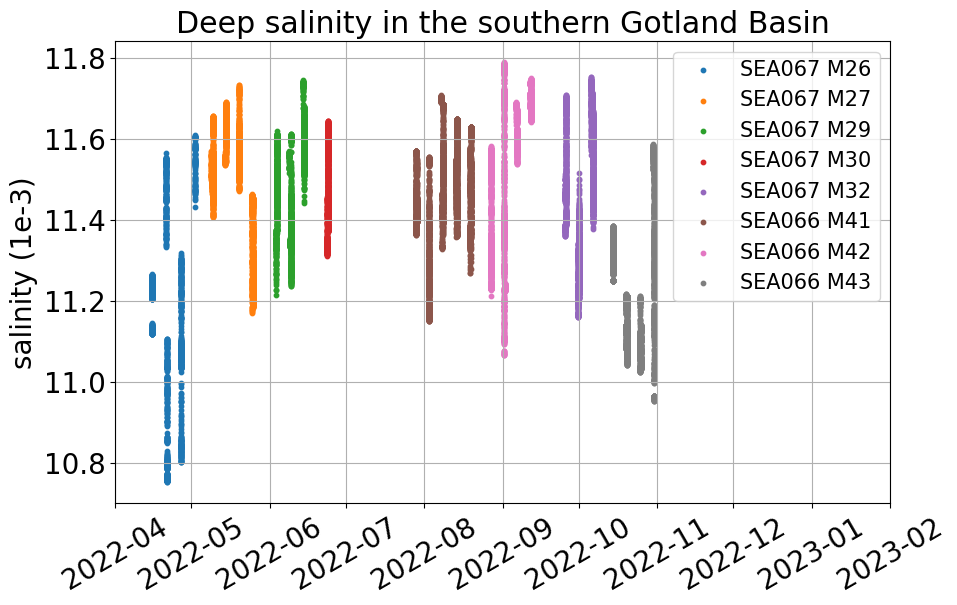

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
for name, ds in ds_delayed.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    ax.scatter(ds.time, ds.salinity, label=pretty_label, s=10)
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})",
       xlim=(datetime.date(2022,4,1), datetime.date(2023,2,1)),
       title="Deep salinity in the southern Gotland Basin")
plt.grid()

Using the delayed mode datasets we have data at much higher temporal resolution, but we lack the most up to date data, as we need to physically recover the gliders to get the delayed mode data.

### 5. Combine datasets

from the [VOTO stats page](https://observations.voiceoftheocean.org/stats) we see that SEA067 completed three back to back missions in the Gotland basin during April - June 2022

![observations gantt plot](https://observations.voiceoftheocean.org/static/img/glider/gantt_all_ops.png)

Using this information, we can be confident in combining those missions (M26, M27, M29) into one dataset:

In [12]:
ds_gotland = xr.concat((ds_delayed["delayed_SEA067_M26"], ds_delayed["delayed_SEA067_M27"], ds_delayed["delayed_SEA067_M29"]), dim='obs')

We can now create plots from one dataset, rather than looping through several individual ones

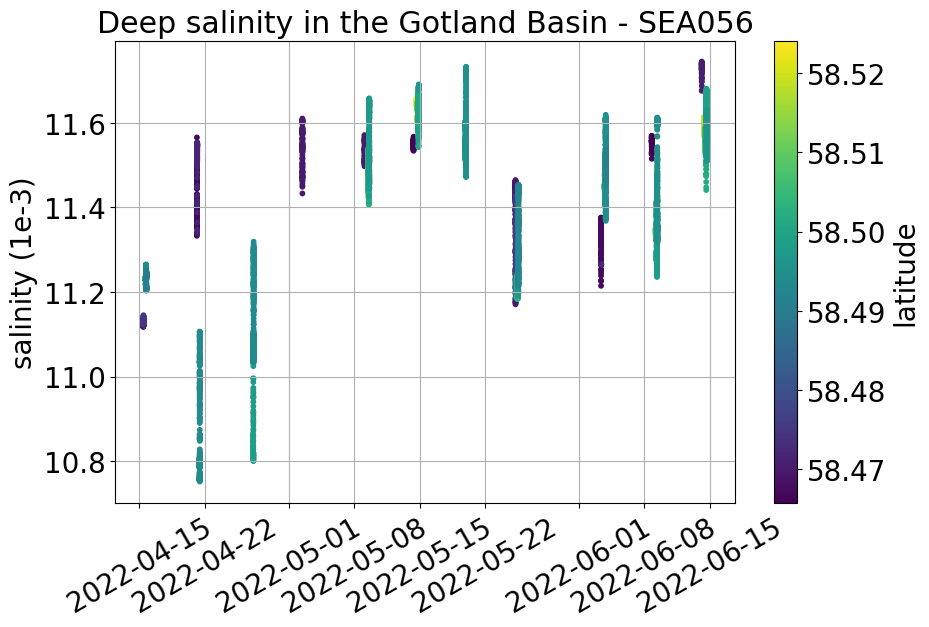

In [13]:
min_depth = 140
fig, ax = plt.subplots(figsize=(10, 6))

col = ax.scatter(ds_gotland.time[ds_gotland.depth> min_depth], ds_gotland.salinity[ds_gotland.depth> min_depth], c=ds_gotland.latitude[ds_gotland.depth> min_depth],s=10)
plt.setp(ax.get_xticklabels(), rotation=30);
fig.colorbar(ax=ax, mappable=col, label="latitude")
ax.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})", title="Deep salinity in the Gotland Basin - SEA056")
plt.grid()

------------------------

# Miscellaneous tips

- To save time and avoid reprocessing from scratch each time, you can always save your xarray dataset with `ds.to_netcdf("/path/filename.nc")` and load it back in with `ds = xr.open_dataset("/path/filename.nc")`. *However* ensure that your workflow can recreate your results from the data download onward, so that any changes to the orginal datasets (more data in NRT, better QC etc.) can be incorporated into your analysis
- Save figures with `fig.savefig("figures/fig_name.png")`
- You can save download time and disk space by downloading only the variables you need. Pass them as a list to `utils.download_glider_dataset`. Similarly, you can pass a dictionary of constraints
- To force a re-run from fresh data, delete the `voto_erddap_data_cache` directory